### Code used in Section 6.2.2: Effect of $\chi N$ on the equilibrium morphology
### Code used in the Chapter 7: Comparisons. 1D SCFT.

Import libraries.

The detect_peaks.py is from:
https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate
import time
import pyfftw
from numba import autojit
from detect_peaks import detect_peaks
%matplotlib inline

Define some helper functions. For more details/comments, see 2D_SCFT.ipynb. 

In [2]:
@autojit
def get_fselector(fa,fb,Ns):
    ka = int(fa*Ns)
    kb = int(fb*Ns)
    sf = np.concatenate((np.zeros(ka+1),np.ones(kb+1)),axis=0).astype(int)
    sft = np.concatenate((np.ones(kb+1),np.zeros(ka+1)),axis=0).astype(int)
    return sf,sft

@autojit
def solve_phi(q,qt,Nx,Na,ds,V):
    ax1 = np.linspace(0,V,num=Nx)
    phi = np.zeros((Nx,2))
    for j in xrange(Nx):
        tmp1 = q[j,:]*qt[j,::-1]
        phi[j,0] = integrate.trapz(tmp1[:Na+1],dx=ds)
        phi[j,1] = integrate.trapz(tmp1[Na:],dx=ds)
    Q = 1./(V) * integrate.trapz(q[:,-1],x=ax1)
    phi = phi/Q
    return phi

The main SCFT looping. For more details, see 2D_SCFT.ipynb.

Here, two sets of initial conditions are specified. The cosines are used for section 6.2.2., and the random uniform is used for chapter 7.

In [27]:
def scft(Nx,fa,V,gam,XN,it,wisdom=None):
    # define spatial resolution (Nx) and number of monomers for each type.
    N = 20
    fb = 1.0-fa
    Na = int(fa*N)
    Nb = int(fb*N)

    # define copolymer sequence contour step-sizes (ds), and contour resolution (Ns).
    ds = 1./(N)
    Ns = int(N)

    # define time step-size (gamma_2 of eqn 6.1a)
    eps = .1

    # define the Flory-Huggins parameter such that X_ab == constant always.
    Xab = XN/N
    
    # define lvs to take snapshot of average density.
    lv = 10

    # initialize empty arrays and initial conditions.
    w = np.zeros((Nx,2))
    C = 0.1 # scaling factor
    
    pts = np.linspace(0,V,Nx)
    w[:,0] = C*np.cos(np.pi*pts/(V)).reshape(-1)
    w[:,1] = -1.*C*np.cos(np.pi*pts/(V)).reshape(-1)
    
    #w[:,:] = C*np.random.uniform(-1.,1.,(Nx,2))
    
    phi = np.zeros((Nx,2))
    q = np.zeros((Nx,Ns+1))
    qt = np.zeros((Nx,Ns+1))
    
    # import pyfftw wisdom if it is defined.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)
    
    # initialise pyfftw arrays.
    qpp = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    qppt = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    qp = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    qpt = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    v = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    vt = pyfftw.empty_aligned((Nx), dtype='complex128', n=16)
    
    # define pyfftw FFT plans.
    fft_object = pyfftw.FFTW(qpp, qp, threads=4)
    ifft_object = pyfftw.FFTW(qp, v, direction='FFTW_BACKWARD', threads=4)
    
    fft_object = pyfftw.FFTW(qppt, qpt, threads=4)
    ifft_object = pyfftw.FFTW(qpt, vt, direction='FFTW_BACKWARD', threads=4)

    # get the monomer configuration in the polymer.
    f, ft = get_fselector(fa,fb,Ns)

    # get wavenumber and spatial grid.
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    k = freqs
    k2 = k**2
    dx = np.linspace(0,V,num=Nx)

    # calculate xi and phi at first iteration. Step 1 of algorithm.
    pressure = (w[:,0] + w[:,1])/2
    pressure = pressure-pressure.mean()
    xi = Xab*N-pressure

    # calculate the initial phi values.
    phi[:,0] = (w[:,0] - xi)/(Xab*N)
    phi[:,1] = (w[:,1] - xi)/(Xab*N)
    
    # initial some arrays for the average concentration.
    avgConc = np.zeros(it/lv)
    p0 = np.zeros(it/lv)
    p1 = np.zeros(it/lv)
    j = 0
    
    # for each subsequent iteration...
    for i in xrange(it):
        # store the old phi values for equation 6.1c, step 4 of the algorithm.
        phi_old = np.copy(phi)

        # define initial conditions (eqn 5.30)
        q[:,0] = 1.
        qt[:,0] = 1.

        # solve the MDE.
        for s in xrange(1,Ns+1):
            # solving MDE: substep 1 (eqn 6.5a)
            qpp[:] = np.exp(-0.5*ds*w[:,f[s]])*q[:,s-1]
            qppt[:] = np.exp(-0.5*ds*w[:,ft[s]])*qt[:,s-1]
            
            # solving MDE: substep 2 (eqn 6.5b)
            qp[:] = np.exp(-4.*np.pi**2*ds*k2/(V**2))*fft_object(qpp)
            qpt[:] = np.exp(-4.*np.pi**2*ds*k2/(V**2))*fft_object(qppt)
            
            # solving MDE: substep 3 (eqn 6.5c)
            q[:,s] = np.exp(-0.5*ds*w[:,f[s]])*ifft_object(qp).real
            qt[:,s] = np.exp(-0.5*ds*w[:,ft[s]])*ifft_object(qpt).real
        
        # get the phi values using helper function.
        phi = solve_phi(q,qt,Nx,int(fa*Ns),ds,V)

        # get the pressure term (2nd term of xi, equation 5.47e).
        pressure = (w[:,0] + w[:,1])/2
        pressure = pressure-pressure.mean()    

        # equation 6.1c.
        delta_phi = phi_old.sum(axis=1)-phi.sum(axis=1)
        delta_phi = delta_phi-delta_phi.mean()

        # update w(i) to w(i+1), equation 6.1a. This completes substep 4 of the algorithm.
        w[:,0] = w[:,0]+gam*(Xab*N*(phi[:,1]-0.5)+pressure-w[:,0])-eps*(delta_phi)
        w[:,1] = w[:,1]+gam*(Xab*N*(phi[:,0]-0.5)+pressure-w[:,1])-eps*(delta_phi)
        
        # get average concentrations.
        if i%lv==0:
            u = phi[:,0] - phi[:,1]
            u0 = integrate.trapz(u,x=dx)
            avgConc[j] = u0 / V
            p0[j] = integrate.trapz(phi[:,0],x=dx) / V
            p1[j] = integrate.trapz(phi[:,1],x=dx) / V
            j+=1
        
    wisdom = pyfftw.export_wisdom()

    return avgConc, phi, p0, p1

Run the SCFT for multiple domain sizes and XN values. Recall that XN is the Flory-Huggins multiplied by polymerisation index.

In [8]:
# Nx = spatial resolution; fa = fraction of monomer type A
# gam = 'temporal' step-size; it = number of iterations
Nx = 128
fa = 0.5
gam = 0.1
it = 1000

# range of domain sizes
Vs = np.arange(1.0,1.6,0.2)

# range of XN
XNs = np.arange(10.0,10.5,0.1)

Us = np.zeros((len(Vs)*len(XNs),Nx))
tic = time.time()

i = 0
for XN in XNs:
    for V in Vs:
        avgConc, phi, p0, p1 = scft(Nx,fa,V,gam,XN,it)

        U = phi[:,0] - phi[:,1]
        Us[i,:] = U
        i += 1
        
toc = time.time()
print("time taken: %.3fs" %(toc-tic))

time taken: 148.980s


Define some helper functions.

`odtest` checks if
$$ \lvert \max(u) - \min(u) \rvert < 0.1. $$
If this condition is met, assume that the resulting morphology is that of *disordered* (False). Otherwise *ordered* (True).

`oneTwoPeriods` counts the number of peaks.

    Return True, is 1 period detected.
    Return False, if 2 periods are detected
    Return None, if 3 or more periods are detected.

In [9]:
# Order-disorder test. True == order; False == disorder.
def odtest(u):
    if abs(u.max()-u.min()) < 0.1:
        return False
    else:
        return True
    
def oneTwoPeriods(u):
    indexes = detect_peaks(u)
    if len(indexes) == 1:
        return True
    if len(indexes) == 2:
        return False

Load data array for the run used in the master thesis. I saved this because it takes a long time to generate.

In [17]:
Vs = np.arange(1.0,12.0,0.2)
XNs = np.arange(10.0,15.0,0.1)
Us = np.loadtxt("uArrs/SCFT_Us_XN_10-15_V_1-9")

Sort data generated according to number of periods.

    red = disordered,
    green = 1 period,
    blue = 2 periods,
    yellow = 3 or more periods.

In [19]:
green = np.zeros((len(Vs)*len(XNs),2))
red = np.zeros((len(Vs)*len(XNs),2))
blue = np.zeros((len(Vs)*len(XNs),2))
yellow = np.zeros((len(Vs)*len(XNs),2))

i = 0
j = 0
for ii in range(Us.shape[0]):
    U = Us[ii]
    V = Vs[(ii%len(Vs))]
    XN = XNs[(ii/(len(Vs)))]
    
    if odtest(U) == True:
        if oneTwoPeriods(U.real) == True:
            green[i,...] = [V,XN]
        elif oneTwoPeriods(U.real) == False:
            blue[i,...] = [V,XN]
        else:
            yellow[i,...] = [V,XN]
        i += 1
    else:
        red[j,...] = [V,XN]
        j += 1        

Save data array.

In [16]:
#np.savetxt("uArrs/SCFT_Us_XN_10-15_V_1-9", Us)

Load the theoretical DFT curves (Pts1.csv and Pts2.csv). These were calculated using *Mathematica*. See lsa.nb for more details.

In [20]:
Pts1 = np.loadtxt('Pts1.csv',delimiter=',')
Pts2 = np.loadtxt('Pts2.csv',delimiter=',')

ys1 = Pts1[:,1]
xs1 = Pts1[:,0]

ys2 = Pts2[:,1]
xs2 = Pts2[:,0]

Plot the sorted data by means of a scatter plot. The scaling factors
$$ C_x = 1.69696969697, \qquad C_y = 28.362 $$
are determined in eqn 7.40 and eqn 7.39 respectively.

$L_{crit}$'s are taken from the data and $\chi N_{crit}$ is taken from [the paper by Uneyama and Doi [37]](https://pubs.acs.org/doi/abs/10.1021/ma049385m).

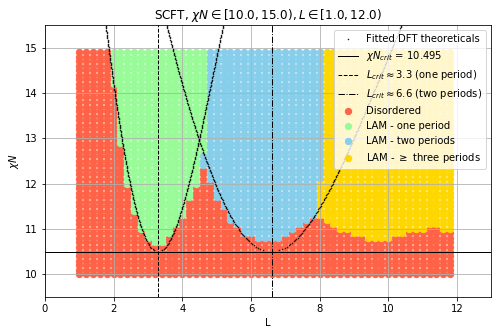

In [23]:
fig1 = plt.figure(figsize=(8,5))
plt.plot(xs1/1.7,(1.-ys1)*28.362,'ko',markersize=0.5,label='Fitted DFT theoreticals')
plt.plot(xs2/1.7,(1.-ys2)*28.362,'ko',markersize=0.5,)
plt.scatter(red[:,0],red[:,1],color='tomato',s=40.0,label='Disordered')
plt.scatter(green[:,0],green[:,1],color='palegreen',s=40.0,label='LAM - one period')
plt.scatter(blue[:,0],blue[:,1],color='skyblue',s=40.0,label='LAM - two periods')
plt.scatter(yellow[:,0],yellow[:,1],color='gold',s=40.0,label=r'LAM - $\geq$ three periods')
plt.axhline(10.495,linewidth=1.0,color='k', label=r'$\chi N_{crit}$ = 10.495')
plt.axvline(3.3,linewidth=1.0,color='k', linestyle='--', label=r'$L_{crit} \approx 3.3$ (one period)')
plt.axvline(6.6,linewidth=1.0,color='k', linestyle='-.', label=r'$L_{crit} \approx 6.6$ (two periods)')
plt.xlim(0.0,13.0)
plt.ylim(9.5,15.5)
plt.xlabel(r'L')
plt.ylabel(r'$\chi N$')
plt.title(r'SCFT, $\chi N \in [10.0,15.0), L \in [1.0,12.0)$')
plt.legend(loc='upper right', ncol=1)
plt.grid()
#fig1 = plt.savefig("SCFT-period.pdf", bbox_inches='tight')
plt.show()

#### Generate the data needed for section 6.2.2.

Sample a couple of $\chi N$ values: 20.0, 40.0, 60.0, 80.0.

In [29]:
Nx = 256
fa = 0.3
dr = 0.1
gam = 0.1
it = 500
V = 6.
XNs = [20.,40.,60.,80.]
Us = np.zeros((len(XNs),Nx))

j = 0
for XN in XNs:
    avgConc, phi, p0, p1 = scft(Nx,fa,V,gam,XN,it)
    U = phi[:,0] - phi[:,1]
    Us[j,:] = U
    j += 1

Plot the results (densitiy differences and the average concentration).

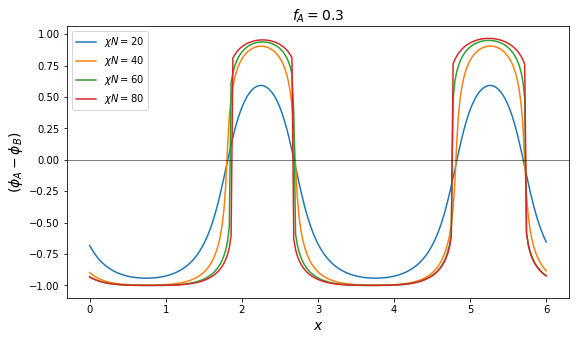

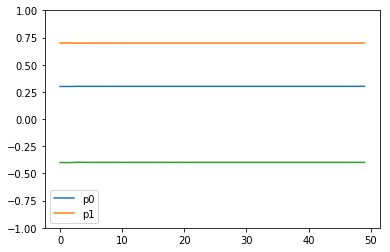

In [30]:
xs = np.linspace(0.,V,Nx)

j = 0
fig0 = plt.figure(figsize=(9,5))

for U in Us:
    plt.plot(xs,U, label=r'$\chi N = %2i$' %XNs[j])
    j += 1
    
plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$(\phi_A - \phi_B$)',fontsize=14)
plt.legend()
plt.title(r'$f_A = 0.3$',fontsize=14)
plt.axhline(0, color='k', linewidth=0.5)
#fig0 = plt.savefig('fA_03.pdf', bbox_inches='tight')
plt.show()
plt.plot(p0,label='p0')
plt.plot(p1,label='p1')
plt.plot(avgConc)
plt.legend()
plt.ylim(-1.,1.)
plt.show()